<a href="https://colab.research.google.com/github/jchen8000/MachineLearning/blob/master/Recommender%20System/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System


https://sdsawtelle.github.io/blog/output/week9-recommender-andrew-ng-machine-learning-with-python.html

https://github.com/kaleko/CourseraML/tree/master/ex8

https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d

## 1. Collaborative Filtering Algorithm

$r(i,j) = 1 $: if user $j$ has rated movie $i$ ($0$ otherwise)

$y^{(i,j)} = $ rating by user $j$ on movie $i$ (if defined)

$\theta^{(j)} = $ parameter vector for user $j$, $ \qquad\theta^{(j)}\in \mathbb{R}^{n+1} $ 

$x^{(i)} = $feature vector for movie $i$



### 1.1 Collaborative Filtering cost function

1. Given $x^{(1)},...,x^{(n_m)}, \textrm{ estimate  }\theta^{(1)},...,\theta^{(n_u)} \textrm{:}$

$\qquad \displaystyle\min_{\theta^{(1)},...,\theta^{(n_u)} } J = \frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n(\theta_k^{(j)})^2$

2. Given $\theta^{(1)},...,\theta^{(n_u)}, \textrm{ estimate  } x^{(1)},...,x^{(n_m)}\textrm{:}$

$\qquad \displaystyle\min_{x^{(1)},...,x^{(n_m)}} J = \frac{1}{2}\sum_{i=1}^{n_m}\sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 + \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n(x_k^{(i)})^2$


3. Minimizing  $x^{(1)},...,x^{(n_m)}, \textrm{ and  }\theta^{(1)},...,\theta^{(n_u)} \textrm{ simultaneously:}$
$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \displaystyle\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 +\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n(\theta_k^{(j)})^2 +  \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n(x_k^{(i)})^2$

$\qquad \displaystyle\min_{\theta^{(1)},...,\theta^{(n_u)},x^{(1)},...,x^{(n_m)} }J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) $

### 1.2 Collaborative Filtering gradient

$\qquad \displaystyle\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}+\lambda x_k^{(i)}$

$\qquad \displaystyle\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}$

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import scipy.optimize #Use for fmincg


## 2. Movie ratings dataset

https://github.com/arturomp/coursera-machine-learning-in-python/blob/master/mlclass-ex8-004/mlclass-ex8/ex8_cofi.py

https://stevenpzchan.github.io/ml_dl_coursera_Andrew_Ng/python/machine-learning-ex8


### 2.1 Load MovieLens datase and Process the data

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls ml-100k/

--2019-07-24 17:37:52--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  15.4MB/s    in 0.3s    

2019-07-24 17:37:52 (15.4 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
dataset = pd.read_csv("ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
items = pd.read_csv("ml-100k/u.item",
                    sep='|',
                    names="movie_id|movie_title|release_date|video_release_date|IMDb_URL|unknown|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|".split("|"),
                    encoding="latin-1")
items.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,NaN


In [5]:
#Set user_id starting from 0 - number_users-1, and same for item_id
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
items.movie_id = items.movie_id.astype('category').cat.codes.values

num_users, num_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
print("Number of Users:", num_users, "; Number of Items:", num_movies, "; Rating is from", dataset.rating.min(), "to", dataset.rating.max())

Number of Users: 943 ; Number of Items: 1682 ; Rating is from 1 to 5


In [0]:
Y = np.zeros((num_movies, num_users))

for index, row in dataset.iterrows():
     # access data using column names
     i_item = row['item_id']
     i_user = row['user_id']
     i_rating = row['rating']
     Y[i_item,i_user] = i_rating

R = (Y>=1)   




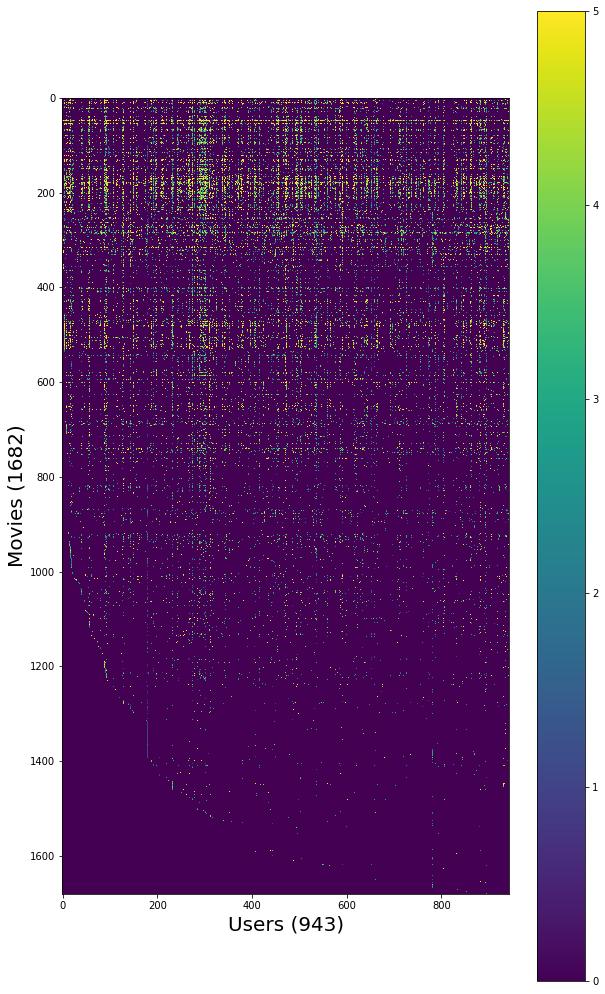

In [7]:
fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%num_movies,fontsize=20)
plt.xlabel('Users (%d)'%num_users,fontsize=20)
plt.show()


### 2.2 Train the Collaborative Filtering Model

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row)
    This is important because without this, a user who hasn't rated any movies
    will have a predicted score of 0 for every movie, when in reality
    they should have a predicted score of [average score of that movie].
    """

    # The mean is only counting movies that were rated
    Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return Y-Ymean, Ymean

In [0]:
def flattenParams(X, Theta):
    """
    Hand this function an X matrix and a Theta matrix and it will flatten
    it into into one long (nm*nf + nu*nf,1) shaped numpy array
    """
    return np.concatenate((X.flatten(), Theta.flatten()))

# A utility function to re-shape the X and Theta will probably come in handy
def reshapeParams(flattened_XandTheta, nm, nu, nf):
    assert flattened_XandTheta.shape[0] == int(num_movies*num_features+num_users*num_features)
    
    reX = flattened_XandTheta[:int(nm*nf)].reshape((nm,nf))
    reTheta = flattened_XandTheta[int(nm*nf):].reshape((nu,nf))
    
    return reX, reTheta

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_=0):
    #COFICOSTFUNC Collaborative filtering cost function
    #   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #
    
    X, Theta = reshapeParams(params, num_movies, num_users, num_features)

    # These are the return values
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    
    ### COST FUNCTION, NO REGULARIZATION
    # X * Theta performed according to low rank matrix vectorization
    squared_error = np.power(np.dot(X,Theta.T) - Y,2)

    # for cost function, sum only i,j for which R(i,j)=1
    J = (1/2.) * np.sum(squared_error * R)
    J = J + (lambda_/2.)*( np.sum( np.power(Theta, 2) ) + np.sum( np.power(X, 2) ) )

    ### GRADIENTS, NO REGULARIZATION
    X_grad = np.dot(( np.dot(X, Theta.T) - Y ) * R, Theta)
    X_grad = X_grad + lambda_*X

    Theta_grad = np.dot((( np.dot(X, Theta.T) - Y ) * R).T, X)
    Theta_grad = Theta_grad + lambda_*Theta
    
    grad = flattenParams(X_grad, Theta_grad)
    
    return J, grad

In [0]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

Ynorm, Ymean = normalizeRatings(Y,R)

In [0]:
# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters  = flattenParams(X,Theta)

# Set options
maxiter = 100
options = {'disp': True, 'maxiter':maxiter}
lambda_=10

In [0]:
from scipy.optimize import minimize

# Create "short hand" for the cost function to be minimized
def costFunc(initial_parameters):
    return cofiCostFunc(initial_parameters, Y, R, num_users, num_movies, num_features, lambda_)


results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)


In [0]:
X, Theta = reshapeParams(results['x'], num_movies, num_users, num_features)

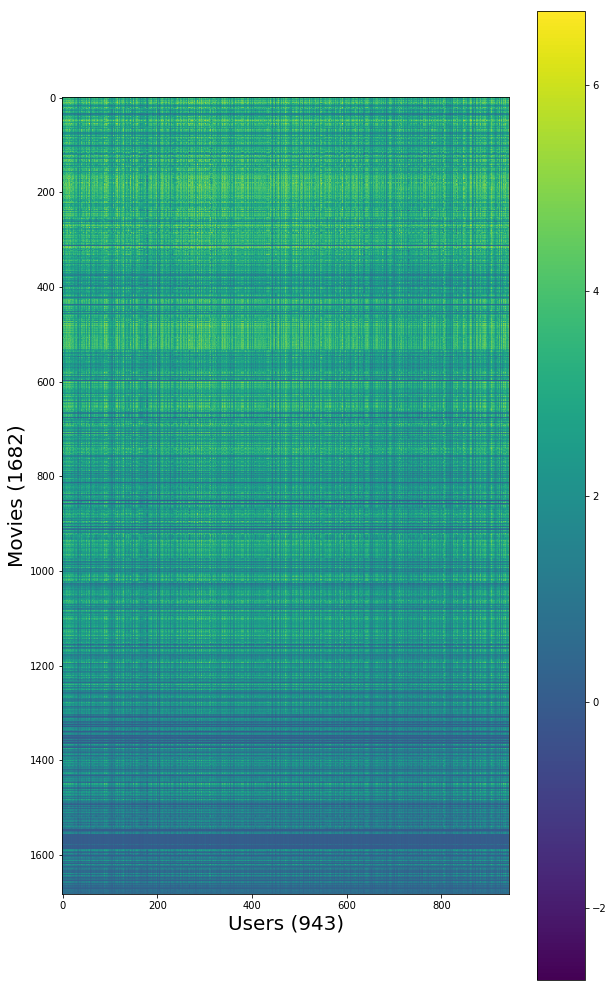

In [15]:
prediction_matrix = X.dot(Theta.T)


fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(prediction_matrix)
plt.colorbar()
plt.ylabel('Movies (%d)'%num_movies,fontsize=20)
plt.xlabel('Users (%d)'%num_users,fontsize=20)
plt.show()

### 2.3 Check Collaborative Filtering Gradient and Cost Function  

In [0]:
#  Reduce the data set size so that this runs faster
num_users = 40
num_movies = 50
num_features = 10
X_chk = X[:num_movies, :num_features]
Theta_chk = Theta[:num_users, :num_features]
Y_chk = Y[:num_movies, :num_users]
R_chk = R[:num_movies, :num_users]

In [17]:
# "...run your cost function. You should expect to see an output of 22.22."
J1, _ = cofiCostFunc(flattenParams(X_chk,Theta_chk),Y_chk,R_chk,num_users,num_movies,num_features)
print( 'Cost with num_users = %d, num_movies = %d, num_features = %d is %0.2f.' % (num_users, num_movies, num_features,J1) )
    
# "...with lambda = 1.5 you should expect to see an output of 31.34."
J2, _ = cofiCostFunc(flattenParams(X_chk,Theta_chk),Y_chk,R_chk,num_users,num_movies,num_features,lambda_=1.5)
print( 'Cost with num_users = %d, num_movies = %d, num_features = %d (and lambda = 1.5) is %0.2f.' % (num_users, num_movies, num_features,J2) )

Cost with num_users = 40, num_movies = 50, num_features = 10 is 103.01.
Cost with num_users = 40, num_movies = 50, num_features = 10 (and lambda = 1.5) is 377.20.


In [0]:
def checkGradient(params, Y, R, num_users, num_movies, num_features, lambda_=0.):
    
    print( 'Numerical Gradient \t cofiGrad \t\t Difference' )
    
    # Compute a numerical gradient with an epsilon perturbation vector
    eps = 0.0001
    nparams = len(params)
    epsvec = np.zeros(nparams)
    # These are my implemented gradient solutions
    _, grads = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_)    

    # Choose 10 random elements of my combined (X, Theta) param vector
    # and compute the numerical gradient for each... print to screen
    # the numerical gradient next to the my cofiGradient to inspect
    
    for i in range(10):
        idx = np.random.randint(0,nparams)
        epsvec[idx] = eps
        loss1, _ = cofiCostFunc(params-epsvec,Y, R, num_users, num_movies, num_features, lambda_)
        loss2, _ = cofiCostFunc(params+epsvec,Y, R, num_users, num_movies, num_features, lambda_)
        grad = (loss2 - loss1) / (2*eps)
        epsvec[idx] = 0
        print( '%0.15f \t %0.15f \t %0.15f' % (grad, grads[idx], grad - grads[idx]) )

In [19]:
print( "Checking gradient with lambda = 0..." )
checkGradient(flattenParams(X_chk, Theta_chk), Y_chk, R_chk, num_users, num_movies, num_features)

print( "\nChecking gradient with lambda = 1.5..." )
checkGradient(flattenParams(X_chk, Theta_chk), Y_chk, R_chk, num_users, num_movies, num_features, lambda_ = 1.5)

Checking gradient with lambda = 0...
Numerical Gradient 	 cofiGrad 		 Difference
1.856235085568869 	 1.856235085545804 	 0.000000000023065
1.606370759645870 	 1.606370759651993 	 -0.000000000006123
1.437190989577175 	 1.437190989681660 	 -0.000000000104485
2.422472811218768 	 2.422472811181649 	 0.000000000037119
-2.388238833006540 	 -2.388238832953995 	 -0.000000000052545
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-1.461398713473727 	 -1.461398713477585 	 0.000000000003857
1.833193456590720 	 1.833193456618140 	 -0.000000000027420
-1.075902733234102 	 -1.075902733210029 	 -0.000000000024073
0.723879433905950 	 0.723879433935580 	 -0.000000000029630

Checking gradient with lambda = 1.5...
Numerical Gradient 	 cofiGrad 		 Difference
-0.711781338509354 	 -0.711781338627882 	 0.000000000118528
-0.608896883420584 	 -0.608896883267191 	 -0.000000000153393
-0.380874451195723 	 -0.380874451197207 	 0.000000000001484
1.917688269088558 	 1.917688269286283 	 -0.000000000197725
0.1

### 2.4 Predict rating for a new user

In [0]:
new_ratings = np.zeros((Y.shape[0],1))
new_ratings[0]   = 4
new_ratings[97]  = 2
new_ratings[6]   = 3
new_ratings[11]  = 5
new_ratings[53]  = 4
new_ratings[63]  = 5
new_ratings[65]  = 3
new_ratings[68]  = 5
new_ratings[182] = 4
new_ratings[225] = 5
new_ratings[354] = 5  

In [0]:
# Add my ratings to the Y matrix, and the relevant row to the R matrix
new_R = new_ratings > 0
Y = np.hstack((Y,new_ratings))
R = np.hstack((R,new_R))

num_movies, num_users = Y.shape
num_features = 10

Ynorm, Ymean = normalizeRatings(Y,R)

In [0]:
# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters  = flattenParams(X,Theta)

In [0]:
results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)

In [0]:
X, Theta = reshapeParams(results['x'], num_movies, num_users, num_features)

In [0]:
# After training the model, now make recommendations by computing
# the predictions matrix
prediction_matrix = X.dot(Theta.T)

# Grab the last user's predictions (since I put my predictions at the
# end of the Y matrix, not the front)
# Add back in the mean movie ratings
new_predictions = prediction_matrix[:,-1] + Ymean.flatten()

In [0]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(new_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

In [0]:
datafile = 'movie_ids.txt'

movies = []
with open(datafile, mode="r", encoding="latin-1") as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))

In [50]:
print( "Top recommendations for you:" )
for i in range(10):
    print( 'Predicting rating %0.1f for movie #%d: %s.' % \
    (new_predictions[pred_idxs_sorted[i]], pred_idxs_sorted[i],items.loc[pred_idxs_sorted[i]].movie_title)  )
    
print( "\nThe ratings provided:" )
for i in range(len(new_ratings)):
    if new_ratings[i] > 0:
        print( 'Rated %d for movie #%d: %s.' % (new_ratings[i], i, items.loc[i].movie_title)  )    

Top recommendations for you:
Predicting rating 8.6 for movie #49: Star Wars (1977).
Predicting rating 8.5 for movie #312: Titanic (1997).
Predicting rating 8.4 for movie #63: Shawshank Redemption, The (1994).
Predicting rating 8.3 for movie #173: Raiders of the Lost Ark (1981).
Predicting rating 8.3 for movie #317: Schindler's List (1993).
Predicting rating 8.2 for movie #171: Empire Strikes Back, The (1980).
Predicting rating 8.2 for movie #271: Good Will Hunting (1997).
Predicting rating 8.1 for movie #126: Godfather, The (1972).
Predicting rating 8.1 for movie #21: Braveheart (1995).
Predicting rating 8.1 for movie #11: Usual Suspects, The (1995).

The ratings provided:
Rated 4 for movie #0: Toy Story (1995).
Rated 3 for movie #6: Twelve Monkeys (1995).
Rated 5 for movie #11: Usual Suspects, The (1995).
Rated 4 for movie #53: Outbreak (1995).
Rated 5 for movie #63: Shawshank Redemption, The (1994).
Rated 3 for movie #65: While You Were Sleeping (1995).
Rated 5 for movie #68: Forrest

## 3. Others

In [0]:
!wget https://github.com/jchen8000/MachineLearning/blob/master/Recommender%20System/ex8_movies.mat?raw=true
  
!wget https://github.com/jchen8000/MachineLearning/blob/master/Recommender%20System/ex8_movieParams.mat?raw=true  
  
!wget https://raw.githubusercontent.com/jchen8000/MachineLearning/master/Recommender%20System/movie_ids.txt 

In [0]:
datafile = 'ex8_movies.mat?raw=true'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']    #Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
R = mat['R']    #R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
nm, nu = Y.shape

In [0]:
datafile = 'ex8_movieParams.mat?raw=true'
mat = scipy.io.loadmat( datafile )
X = mat['X']
Theta = mat['Theta']
num_users = int(mat['num_users'])
num_movies = int(mat['num_movies'])
num_features = int(mat['num_features'])

In [0]:
def cofiCostFunc(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    # Unfold the X and Theta matrices from the flattened params
    X, Theta = reshapeParams(myparams, mynm, mynu, mynf)
  
    # Note: 
    # X Shape is (nm x nf), Theta shape is (nu x nf), Y and R shape is (nm x nu)
    # Behold! Complete vectorization
    
    # First dot theta and X together such that you get a matrix the same shape as Y
    term1 = myX.dot(myTheta.T)
    
    # Then element-wise multiply that matrix by the R matrix
    # so only terms from movies which that user rated are counted in the cost
    term1 = np.multiply(term1,myR)
    
    # Then subtract the Y- matrix (which has 0 entries for non-rated
    # movies by each user, so no need to multiply that by myR... though, if
    # a user could rate a movie "0 stars" then myY would have to be element-
    # wise multiplied by myR as well) 
    # also square that whole term, sum all elements in the resulting matrix,
    # and multiply by 0.5 to get the cost
    cost = 0.5 * np.sum( np.square(term1-myY) )
    
    # Regularization stuff
    cost += (mylambda/2.) * np.sum(np.square(myTheta))
    cost += (mylambda/2.) * np.sum(np.square(myX))
    
    return cost

In [0]:
def cofiGrad(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    # Unfold the X and Theta matrices from the flattened params
    myX, myTheta = reshapeParams(myparams, mynm, mynu, mynf)

    # First the X gradient term 
    # First dot theta and X together such that you get a matrix the same shape as Y
    term1 = myX.dot(myTheta.T)
    # Then multiply this term by myR to remove any components from movies that
    # weren't rated by that user
    term1 = np.multiply(term1,myR)
    # Now subtract the y matrix (which already has 0 for nonrated movies)
    term1 -= myY
    # Lastly dot this with Theta such that the resulting matrix has the
    # same shape as the X matrix
    Xgrad = term1.dot(myTheta)
    
    # Now the Theta gradient term (reusing the "term1" variable)
    Thetagrad = term1.T.dot(myX)

    # Regularization stuff
    Xgrad += mylambda * myX
    Thetagrad += mylambda * myTheta
    
    return flattenParams(Xgrad, Thetagrad)

In [0]:
datafile = 'movie_ids.txt'
  
  
# So, this file has the list of movies and their respective index in the Y vector
# Let's make a list of strings to reference later
movies = []
with open(datafile, mode="r", encoding="latin-1") as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))

# Rather than rate some movies myself, I'll use what was built-in to the homework
# (just so I can check my solutions)
my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5  

In [0]:
datafile = 'ex8_movies.mat?raw=true'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
# We'll use 10 features
num_features = 10

In [0]:
Ynorm, Ymean = normalizeRatings(Y,R)

In [0]:
# Generate random initial parameters, Theta and X
X = np.random.rand(num_movies,num_features)
Theta = np.random.rand(num_users,num_features)
myflat = flattenParams(X, Theta)

# Regularization parameter of 10 is used (as used in the homework assignment)
mylambda = 10.

# Training the actual model with fmin_cg
result = scipy.optimize.fmin_cg(cofiCostFunc, x0=myflat, fprime=cofiGrad, \
                               args=(Y,R,num_users,num_movies,num_features,mylambda), \
                                maxiter=50,disp=True,full_output=True)

NameError: ignored

In [0]:
# Reshape the trained output into sensible "X" and "Theta" matrices
resX, resTheta = reshapeParams(result[0], num_movies, num_users, num_features)

# After training the model, now make recommendations by computing
# the predictions matrix
prediction_matrix = resX.dot(resTheta.T)

# Grab the last user's predictions (since I put my predictions at the
# end of the Y matrix, not the front)
# Add back in the mean movie ratings
my_predictions = prediction_matrix[:,-1] + Ymean.flatten()

In [0]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(my_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

print( "Top recommendations for you:" )
for i in range(10):
    print( 'Predicting rating %0.1f for movie %s.' % \
    (my_predictions[pred_idxs_sorted[i]],movies[pred_idxs_sorted[i]])  )
    
print( "\nOriginal ratings provided:" )
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print( 'Rated %d for movie %s.' % (my_ratings[i],movies[i])  )

Top recommendations for you:
Predicting rating 8.4 for movie Shawshank Redemption, The (1994).
Predicting rating 8.4 for movie Titanic (1997).
Predicting rating 8.3 for movie Star Wars (1977).
Predicting rating 8.3 for movie Schindler's List (1993).
Predicting rating 8.2 for movie Raiders of the Lost Ark (1981).
Predicting rating 8.1 for movie Usual Suspects, The (1995).
Predicting rating 8.1 for movie Good Will Hunting (1997).
Predicting rating 8.0 for movie Braveheart (1995).
Predicting rating 8.0 for movie Wrong Trousers, The (1993).
Predicting rating 8.0 for movie Empire Strikes Back, The (1980).

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 for m

## 3. MovieLens Dataset

In [0]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls ml-100k/

In [0]:
dataset = pd.read_csv("ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
#Set user_id starting from 0 - number_users-1, and same for item_id
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

number_users, number_items = len(dataset.user_id.unique()), len(dataset.item_id.unique())
print("Number of Users:", number_users, "; Number of Items:", number_items, "; Rating is from", dataset.rating.min(), "to", dataset.rating.max())

Number of Users: 943 ; Number of Items: 1682 ; Rating is from 1 to 5


In [0]:
y = np.zeros((number_items, number_users))

for index, row in dataset.iterrows():
     # access data using column names
     i_item = row['item_id']
     i_user = row['user_id']
     i_rating = row['rating']
     y[i_item,i_user] = i_rating


In [0]:
fig = plt.figure(figsize=(10,10*(1682./943.)))
plt.imshow(y)
plt.colorbar()
plt.ylabel('Movies (%d)'%number_items,fontsize=20)
plt.xlabel('Users (%d)'%number_users,fontsize=20)
plt.show()

In [0]:
r = (y>=1)

In [0]:
items = pd.read_csv("ml-100k/u.item",
                    sep='|',
                    names="movie id|movie title|release date|video release date|IMDb URL|unknown|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|".split("|"),
                    encoding="latin-1")
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,NaN
